In [67]:
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [68]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [69]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [70]:
#work with categorial sex feature
data['Sex'] = np.where(data['Sex']=='male',1,0)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,S


In [71]:
for i in range(0,len(data)):
    ticket = data.iloc[i,8].split()
    try:
        data.iloc[i,8] = int(ticket[-1])
    except:
        data.iloc[i,8] = 0
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,S


In [72]:
data = data.drop(['Name','PassengerId'],axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22,1,0,21171,7.2500,NaN,S
1,1,1,0,38,1,0,17599,71.2833,C85,C
2,1,3,0,26,0,0,3101282,7.9250,NaN,S
3,1,1,0,35,1,0,113803,53.1000,C123,S
4,0,3,1,35,0,0,373450,8.0500,NaN,S


In [73]:
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [74]:
data = data.drop(['Cabin'], axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,1,22,1,0,21171,7.2500,S
1,1,1,0,38,1,0,17599,71.2833,C
2,1,3,0,26,0,0,3101282,7.9250,S
3,1,1,0,35,1,0,113803,53.1000,S
4,0,3,1,35,0,0,373450,8.0500,S


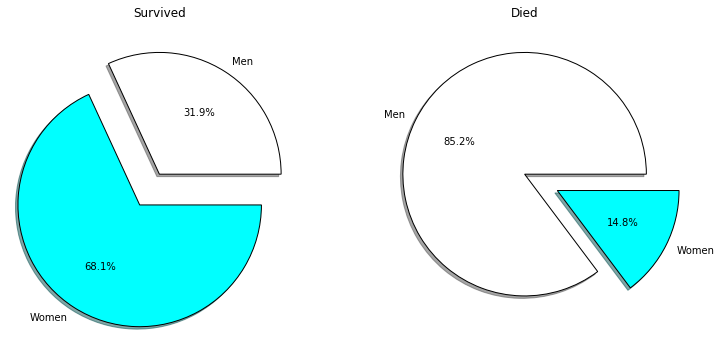

In [75]:
data_pos = data[data['Survived']==1]
data_neg = data[data['Survived']==0]
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.pie([sum(data_pos['Sex'])/len(data_pos),(len(data_pos)-sum(data_pos['Sex']))/len(data_pos)],
                                             labels=['Men', 'Women'], explode=[0, 0.3], autopct = '%1.1f%%', shadow=True,
       colors=['white','cyan'])
plt.title('Survived')
plt.subplot(222)
plt.pie([sum(data_neg['Sex'])/len(data_neg),(len(data_neg)-sum(data_neg['Sex']))/len(data_neg)],
                                             labels=['Men', 'Women'], explode=[0, 0.3], autopct = '%1.1f%%', shadow=True,
       colors=['white','cyan'])
plt.title('Died')
plt.show()

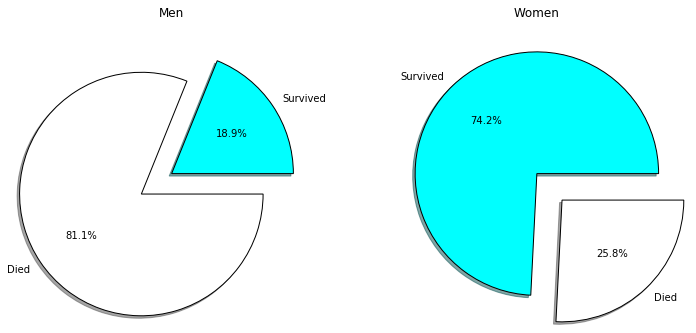

In [76]:
data_men = data[data['Sex']==1]
data_women = data[data['Sex']==0]
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.pie([sum(data_men['Survived'])/len(data_men),(len(data_men)-sum(data_men['Survived']))/len(data_men)],
                                             labels=['Survived', 'Died'], explode=[0, 0.3], autopct = '%1.1f%%', shadow=True,
       colors=['cyan','white'])
plt.title('Men')
plt.subplot(222)
plt.pie([sum(data_women['Survived'])/len(data_women),(len(data_women)-sum(data_women['Survived']))/len(data_women)],
                                             labels=['Survived', 'Died'], explode=[0, 0.3], autopct = '%1.1f%%', shadow=True,
       colors=['cyan','white'])
plt.title('Women')
plt.show()

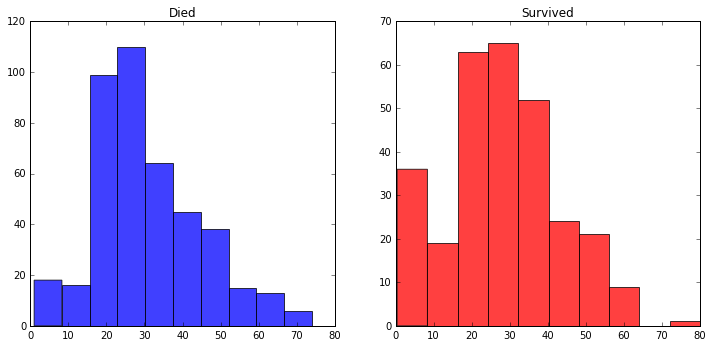

In [77]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.hist(data_neg['Age'].dropna(), bins=10, color='b', alpha=0.75)
plt.title('Died')
plt.subplot(222)
plt.hist(data_pos['Age'].dropna(), bins=10, color='r', alpha=0.75)
plt.title('Survived')
plt.show()

In [78]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,1,22,1,0,21171,7.2500,S
1,1,1,0,38,1,0,17599,71.2833,C
2,1,3,0,26,0,0,3101282,7.9250,S
3,1,1,0,35,1,0,113803,53.1000,S
4,0,3,1,35,0,0,373450,8.0500,S


In [79]:
print('Выживших в выборке {:.2f} %, погибших в выборке: {:.2f} %'.format(sum(data.Survived)/len(data)*100,(1-sum(data.Survived)/len(data))*100))

Выживших в выборке 38.38 %, погибших в выборке: 61.62 %


In [80]:
#let's insert age categpries and try 3 variates nan's replacing
for i in range(0,len(data)):
    age = data.iloc[i,3]
    if math.isnan(data.iloc[i,3]):
        data.iloc[i,3] = 'none group'
    elif int(age)<10:
        data.iloc[i,3] = '<10'
    elif 10<=int(age)<20:
        data.iloc[i,3] = '10-20'
    elif 20<=int(age)<30:
        data.iloc[i,3] = '20-30'
    elif 30<=int(age)<40:
        data.iloc[i,3] = '30-40'
    elif 40<=int(age)<50:
        data.iloc[i,3] = '40-50'
    elif 50<=int(age)<60:
        data.iloc[i,3] = '50-60'
    elif 60<=int(age)<70:
        data.iloc[i,3] = '60-70'
    elif 70<=int(age)<80:
        data.iloc[i,3] = '70-80'
    elif 80<=int(age)<90:
        data.iloc[i,3] = '80-90'
    elif int(age)>90:
        data.iloc[i,3] = '>90'
    data.iloc[i,1] = str(data.iloc[i,1])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,1,20-30,1,0,21171,7.2500,S
1,1,1,0,30-40,1,0,17599,71.2833,C
2,1,3,0,20-30,0,0,3101282,7.9250,S
3,1,1,0,30-40,1,0,113803,53.1000,S
4,0,3,1,30-40,0,0,373450,8.0500,S


In [81]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [82]:
data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [83]:
print(data.isnull().sum())
print(len(data))

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64
891


In [84]:
#Embarked nan replacing
data[data.isnull().any(axis=1)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,0,30-40,0,0,113572,80,NaN
829,1,1,0,60-70,0,0,113572,80,NaN


In [85]:
data.describe()

,Survived,Sex,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.647587,0.523008,0.381594,32.204208
std,0.486592,0.477990,1.102743,0.806057,49.693429
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.910400
50%,0.000000,1.000000,0.000000,0.000000,14.454200
75%,1.000000,1.000000,1.000000,0.000000,31.000000
max,1.000000,1.000000,8.000000,6.000000,512.329200


In [86]:
data.iloc[61,8]=data[(data['Pclass']=='1') & (data['Fare']>60) & (data['Fare']<100) & (data['Age']=='30-40')]['Embarked'].value_counts().index[0]
data.iloc[829,8]=data[(data['Pclass']=='1') & (data['Fare']>60) & (data['Fare']<100) & (data['Age']=='60-70')]['Embarked'].value_counts().index[0]

In [87]:
print(data.isnull().sum())
print(len(data))

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64
891


In [88]:
encoder=DictVectorizer(sparse=False).fit(data[['Age','Embarked','Pclass']].T.to_dict().values())
data_cat = encoder.transform(data[['Age','Embarked','Pclass']].T.to_dict().values())
scaler = StandardScaler().fit(data['Fare'])
data_real = scaler.transform(data['Fare'])
data_cat = pd.DataFrame(data_cat, columns=[encoder.feature_names_])
data_real = pd.DataFrame(data_real,columns=['Fare'])
data_cat.head()

E:\Рабочий софт\Анаконда\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Рабочий софт\Анаконда\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Age=10-20,Age=20-30,Age=30-40,Age=40-50,Age=50-60,Age=60-70,Age=70-80,Age=80-90,Age=<10,Age=none group,Embarked=C,Embarked=Q,Embarked=S,Pclass=1,Pclass=2,Pclass=3
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


In [89]:
data = data.drop(['Fare','Age','Embarked','Pclass'], axis=1)
data = pd.concat([data, data_cat, data_real], axis=1, join_axes=[data.index])
data.head()

,Survived,Sex,SibSp,Parch,Ticket,Age=10-20,Age=20-30,Age=30-40,Age=40-50,Age=50-60,...,Age=80-90,Age=<10,Age=none group,Embarked=C,Embarked=Q,Embarked=S,Pclass=1,Pclass=2,Pclass=3,Fare
0,0,1,1,0,21171,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.502445
1,1,0,1,0,17599,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0.786845
2,1,0,0,0,3101282,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.488854
3,1,0,1,0,113803,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0.420730
4,0,1,0,0,373450,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,-0.486337


In [90]:
label = data['Survived']
data = data.drop(['Survived'], axis=1)

In [91]:
data.head()

,Sex,SibSp,Parch,Ticket,Age=10-20,Age=20-30,Age=30-40,Age=40-50,Age=50-60,Age=60-70,...,Age=80-90,Age=<10,Age=none group,Embarked=C,Embarked=Q,Embarked=S,Pclass=1,Pclass=2,Pclass=3,Fare
0,1,1,0,21171,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.502445
1,0,1,0,17599,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0.786845
2,0,0,0,3101282,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.488854
3,0,1,0,113803,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0.420730
4,1,0,0,373450,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.486337


In [92]:
class_res = []
#LogisticRegression grid_search
params = {
    'C':[0.25,0.5,1,2,5,10,15],
    'class_weight':['balanced', None],
    'max_iter':[70,100,200],
    'penalty':['l2','l1']
}
grid_cv_log = GridSearchCV(LogisticRegression(), params, scoring='accuracy', cv=3)
grid_cv_log.fit(data.as_matrix(),label.as_matrix())
class_res.append(['logReg',grid_cv_log.best_score_,grid_cv_log.best_params_])
print(grid_cv_log.best_score_)

0.803591470258


In [93]:
params = {
    'n_neighbors':[3,5,7]
}
grid_cv_kN = GridSearchCV(KNeighborsClassifier(), params, scoring = 'accuracy', cv=3)
grid_cv_kN.fit(data.as_matrix(),label.as_matrix())
class_res.append(['KN',grid_cv_kN.best_score_,grid_cv_kN.best_params_])
print(grid_cv_kN.best_score_)

0.659932659933


In [94]:
params = {
    'n_estimators':[10,20,50,70],
    'max_depth':[30,50,None],
    'n_jobs':[-1]
}
grid_cv_rndForest = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring = 'accuracy', cv=3)
grid_cv_rndForest.fit(data.as_matrix(),label.as_matrix())
class_res.append(['RFC',grid_cv_rndForest.best_score_,grid_cv_rndForest.best_params_])
print(grid_cv_rndForest.best_score_)

0.811447811448


In [95]:
params = {
    'learning_rate':[1,2,3],
    'n_estimators':[10,30,50,70],
    'base_estimator':[DecisionTreeClassifier(), LogisticRegression()]
}
grid_cv_ada = GridSearchCV(AdaBoostClassifier(), params, n_jobs=-1, scoring = 'accuracy', cv=3)
grid_cv_ada.fit(data.as_matrix(),label.as_matrix())
class_res.append(['Ada',grid_cv_ada.best_score_,grid_cv_ada.best_params_])
print(grid_cv_ada.best_score_)

0.800224466891


In [96]:
params = {
    'max_depth': [10,20,50,None],
    'class_weight': [None, 'balanced']
}
grid_cv_dTree = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=-1, scoring = 'accuracy', cv=3)
grid_cv_dTree.fit(data.as_matrix(),label.as_matrix())
class_res.append(['DTree',grid_cv_dTree.best_score_,grid_cv_dTree.best_params_])
print(grid_cv_dTree.best_score_)

0.817059483726


In [97]:
params = {
    'class_weight': [None, 'balanced'],
    'penalty': ['l2','l1']
}
grid_cv_SGD = GridSearchCV(SGDClassifier(), params, n_jobs=-1, scoring = 'accuracy', cv=3)
grid_cv_SGD.fit(data.as_matrix(),label.as_matrix())
class_res.append(['SGD',grid_cv_SGD.best_score_,grid_cv_SGD.best_params_])
print(grid_cv_SGD.best_score_)

0.615039281706


In [98]:
for i in range(0,len(class_res)):
    tmp = i
    for j in range(i+1,len(class_res)):
        if class_res[j][1]>class_res[tmp][1]:
            tmp=j
    chg = class_res[tmp]
    class_res[tmp] = class_res[i]
    class_res[i] = chg
class_res[0:4]

[['DTree', 0.81705948372615034, {'class_weight': None, 'max_depth': 10}],
 ['RFC',
  0.81144781144781142,
  {'max_depth': None, 'n_estimators': 20, 'n_jobs': -1}],
 ['logReg',
  0.80359147025813693,
  {'C': 5, 'class_weight': 'balanced', 'max_iter': 70, 'penalty': 'l1'}],
 ['Ada',
  0.80022446689113358,
  {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
               max_features=None, max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               presort=False, random_state=None, splitter='best'),
   'learning_rate': 2,
   'n_estimators': 70}]]

In [109]:
clf_1 = VotingClassifier([('DFC', DecisionTreeClassifier(class_weight=None, max_depth=10)),
                          ('RFC', RandomForestClassifier(max_depth=None, n_estimators=20)),
                         ('ogReg', LogisticRegression(penalty='l1', C=5, max_iter=70))], voting='hard')
clf_2 = VotingClassifier([('DFC', DecisionTreeClassifier(class_weight=None, max_depth=10)),
                         ('LogReg', LogisticRegression(penalty='l1', C=5, max_iter=70)),
                         ('Ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=2,n_estimators=70))])
cross_1 = cross_val_score(clf_1, data.as_matrix(), label.as_matrix(), cv=5, scoring='accuracy')
cross_2 = cross_val_score(clf_2, data.as_matrix(), label.as_matrix(), cv=5, scoring='accuracy')
print('Первый вариант: ', cross_1.mean())
print('Второй вариант: ', cross_2.mean())

Первый вариант:  0.833956961997
Второй вариант:  0.827202834824


In [100]:
clf_3 = xgb.XGBClassifier()
cross_3 = cross_val_score(clf_3, data.as_matrix(), label.as_matrix(), cv=5, scoring='accuracy')
print(cross_3.mean())

0.833957245707


In [101]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [102]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [103]:
test['Sex'] = np.where(test['Sex']=='male',1,0)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S


In [104]:
for i in range(0,len(test)):
    ticket = test.iloc[i,7].split()
    try:
        test.iloc[i,7] = int(ticket[-1])
    except:
        test.iloc[i,7] = 0
test = test.drop(['Name','PassengerId','Cabin'],axis=1)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,1,34.5,0,0,330911,7.8292,Q
1,3,0,47.0,1,0,363272,7.0000,S
2,2,1,62.0,0,0,240276,9.6875,Q
3,3,1,27.0,0,0,315154,8.6625,S
4,3,0,22.0,1,1,3101298,12.2875,S


In [105]:
for i in range(0,len(test)):
    age = test.iloc[i,2]
    if math.isnan(test.iloc[i,2]):
        test.iloc[i,2] = 'none group'
    elif int(age)<10:
        test.iloc[i,2] = '<10'
    elif 10<=int(age)<20:
        test.iloc[i,2] = '10-20'
    elif 20<=int(age)<30:
        test.iloc[i,2] = '20-30'
    elif 30<=int(age)<40:
        test.iloc[i,2] = '30-40'
    elif 40<=int(age)<50:
        test.iloc[i,2] = '40-50'
    elif 50<=int(age)<60:
        test.iloc[i,2] = '50-60'
    elif 60<=int(age)<70:
        test.iloc[i,2] = '60-70'
    elif 70<=int(age)<80:
        test.iloc[i,2] = '70-80'
    elif 80<=int(age)<90:
        test.iloc[i,2] = '80-90'
    elif int(age)>90:
        test.iloc[i,2] = '>90'
    test.iloc[i,0] = str(test.iloc[i,0])
test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,1,30-40,0,0,330911,7.8292,Q
1,3,0,40-50,1,0,363272,7.0000,S
2,2,1,60-70,0,0,240276,9.6875,Q
3,3,1,20-30,0,0,315154,8.6625,S
4,3,0,20-30,1,1,3101298,12.2875,S


In [106]:
test[test.isnull().any(axis=1)]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,3,1,60-70,0,0,3701,NaN,S


In [107]:
test.iloc[152,6] = test[(test['Pclass']=='3') & (test['Embarked']=='S')]['Fare'].mean()
test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,1,30-40,0,0,330911,7.8292,Q
1,3,0,40-50,1,0,363272,7.0000,S
2,2,1,60-70,0,0,240276,9.6875,Q
3,3,1,20-30,0,0,315154,8.6625,S
4,3,0,20-30,1,1,3101298,12.2875,S


In [108]:
test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [110]:
test_cat = encoder.transform(test[['Age','Embarked','Pclass']].T.to_dict().values())
test_real = scaler.transform(test['Fare'])
test_cat = pd.DataFrame(test_cat, columns=[encoder.feature_names_])
test_real = pd.DataFrame(test_real,columns=['Fare'])
test = test.drop(['Fare','Age','Embarked','Pclass'], axis=1)
test = pd.concat([test, test_cat, test_real], axis=1, join_axes=[test.index])
test.head()

E:\Рабочий софт\Анаконда\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Sex,SibSp,Parch,Ticket,Age=10-20,Age=20-30,Age=30-40,Age=40-50,Age=50-60,Age=60-70,...,Age=80-90,Age=<10,Age=none group,Embarked=C,Embarked=Q,Embarked=S,Pclass=1,Pclass=2,Pclass=3,Fare
0,1,0,0,330911,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,-0.490783
1,0,1,0,363272,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,-0.507479
2,1,0,0,240276,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,-0.453367
3,1,0,0,315154,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.474005
4,0,1,1,3101298,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.401017


In [111]:
sample = pd.read_csv('gendermodel.csv')
sample.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [112]:
clf_1 = clf_1.fit(data.as_matrix(),label.as_matrix())
clf_2 = clf_2.fit(data.as_matrix(),label.as_matrix())
clf_3 = clf_3.fit(data.as_matrix(),label.as_matrix())

In [113]:
res_1 = clf_1.predict(test.as_matrix())
res_2 = clf_2.predict(test.as_matrix())
res_3 = clf_3.predict(test.as_matrix())

In [115]:
res_1 = pd.DataFrame(list(zip(sample['PassengerId'].as_matrix(),res_1)), columns=['PassengerId','Survived'])
res_1.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [116]:
res_2 = pd.DataFrame(list(zip(sample['PassengerId'].as_matrix(),res_2)), columns=['PassengerId','Survived'])
res_2.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [117]:
res_3 = pd.DataFrame(list(zip(sample['PassengerId'].as_matrix(),res_3)), columns=['PassengerId','Survived'])
res_3.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [118]:
res_1.to_csv('220117_01.csv', header=True, index=None)
res_2.to_csv('220117_02.csv', header=True, index=None)
res_3.to_csv('220117_03.csv', header=True, index=None)

In [119]:
clf_4 = VotingClassifier([('DFC', DecisionTreeClassifier(class_weight=None, max_depth=10)),
                         ('XgBoost', xgb.XGBClassifier()),
                         ('Ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=2,n_estimators=70))]).fit(data.as_matrix(),label.as_matrix())
res_4 = clf_4.predict(test.as_matrix())
res_4 = pd.DataFrame(list(zip(sample['PassengerId'].as_matrix(),res_4)), columns=['PassengerId','Survived'])
res_4.to_csv('220117_04.csv', header=True, index=None)